# Albumentations Modeling Notebook

## Importing Packages

In [22]:
# from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix

%reload_ext autoreload
%autoreload 2
from utils import *


## Augmentation through ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   zoom_range = 0.1, 
                                   horizontal_flip = True,
                                   vertical_flip = True)

train_folder = '../split/train_imb'
val_folder = '../split/val'
test_folder = '../split/test2'

train_generator = train_datagen.flow_from_directory(train_folder, 
                                                    target_size=(224, 224), 
                                                    batch_size = 16,
                                                    class_mode = 'binary',
                                                    seed = 42)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       target_size=(224, 224),
                                                                       batch_size = 16,
                                                                       class_mode = 'binary',
                                                                       seed = 42)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        target_size = (224, 224),
                                                                        batch_size = 1,
                                                                        class_mode = 'binary',
                                                                        shuffle=False)

Found 26500 images belonging to 2 classes.
Found 6626 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
model = create_model((224, 224, 3))
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr=0.01),
              metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [82]:
filepath = '../models/CNN_v1.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit_generator(generator = train_generator,
                              epochs = 20,
                              steps_per_epoch = len(train_generator),
                              callbacks = [earlyStopping, mcp_save],
                              validation_data = val_generator)

## Augmentation through Albumentations

In [3]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test2'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 214,
        class_mode = 'binary',
        seed = 42,
        shuffle = False)

Found 3830 images belonging to 2 classes.
Found 767 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [4]:
X_tr, y_tr = next(train_generator)
X_val, y_val = next(val_generator)
X_tt, y_tt = next(test_generator)

## CNN Model

This model was inspired by the VGG16 model which was the only one that seemed to produce any normal metrics

In [34]:
model2 = create_model((256, 256, 3))
model2.compile(loss = 'binary_crossentropy',
               optimizer = Adam(lr = 0.001),
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve = 'PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [36]:
filepath = '../models/CNN_original.h5'
earlyStopping = EarlyStopping(monitor = 'val_loss', verbose = 0, mode = 'min', patience = 4)
mcp_save = ModelCheckpoint(filepath, save_best_only = True, monitor = 'val_loss', mode = 'min')
history2 = model2.fit(train_generator,
                     epochs = 20,
                     callbacks = [earlyStopping, mcp_save],
                     validation_data = val_generator)

Epoch 1/20
240/240 [==============================] - 3491s 14s/step - loss: 10.5405 - accuracy: 0.7179 - auc_6: 0.7226 - auc_7: 0.8007 - precision_3: 0.7980 - recall_3: 0.7778 - val_loss: 12.2931 - val_accuracy: 0.9513 - val_auc_6: 0.5280 - val_auc_7: 0.9609 - val_precision_3: 0.9598 - val_recall_3: 0.9908
Epoch 2/20
240/240 [==============================] - 2231s 9s/step - loss: 0.8515 - accuracy: 0.8071 - auc_6: 0.8212 - auc_7: 0.8639 - precision_3: 0.8346 - recall_3: 0.8925 - val_loss: 0.2241 - val_accuracy: 0.9587 - val_auc_6: 0.7116 - val_auc_7: 0.9801 - val_precision_3: 0.9587 - val_recall_3: 1.0000
Epoch 3/20
240/240 [==============================] - 2001s 8s/step - loss: 0.4219 - accuracy: 0.8271 - auc_6: 0.8671 - auc_7: 0.9174 - precision_3: 0.8302 - recall_3: 0.9376 - val_loss: 0.3161 - val_accuracy: 0.8687 - val_auc_6: 0.6320 - val_auc_7: 0.9757 - val_precision_3: 0.9591 - val_recall_3: 0.9015
Epoch 4/20
240/240 [==============================] - 1992s 8s/step - loss: 0.3

In [15]:
plt.style.use('seaborn')
sixplot(history2, 'auc_6', 'val_auc_6', 'auc_7', 'val_auc_7', 'precision_3', 'val_precision_3', 'recall_3', 'val_recall_3')

NameError: name 'history2' is not defined

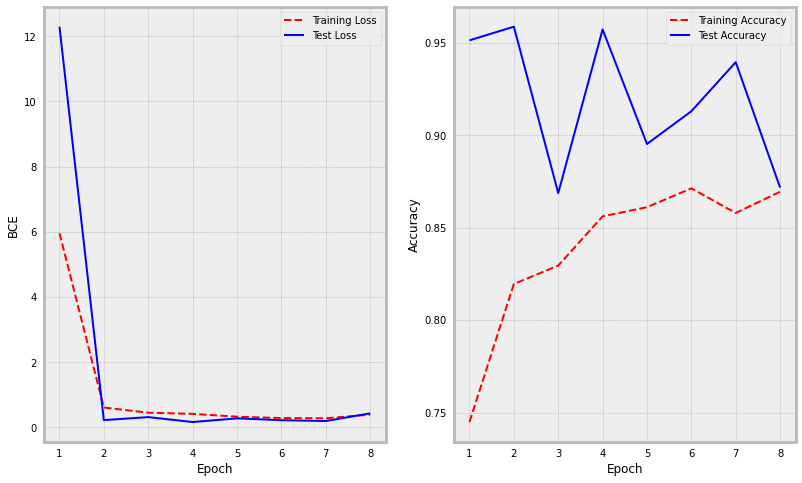

In [47]:
graph_loss(history2)

In [48]:
hist_df_2 = pd.DataFrame(history2.history)
hist_df_2

,loss,accuracy,auc_6,auc_7,precision_3,recall_3,val_loss,val_accuracy,val_auc_6,val_auc_7,val_precision_3,val_recall_3
0,5.959352,0.744909,0.758642,0.826092,0.810069,0.815982,12.293129,0.951327,0.527995,0.960942,0.959762,0.990769
1,0.610057,0.819582,0.845289,0.887599,0.835203,0.915098,0.224131,0.958702,0.711566,0.980095,0.958702,1.000000
2,0.451655,0.829504,0.879377,0.923176,0.841865,0.922397,0.316067,0.868732,0.631978,0.975656,0.959083,0.901538
3,0.416313,0.856136,0.920728,0.954409,0.859495,0.942374,0.165416,0.957227,0.818736,0.990093,0.958641,0.998462
4,0.328959,0.861097,0.927976,0.957397,0.872348,0.932002,0.277417,0.895280,0.785549,0.988379,0.969206,0.920000
5,0.287642,0.871279,0.935500,0.962636,0.884475,0.932386,0.222067,0.912979,0.751758,0.985440,0.959565,0.949231
6,0.280256,0.857963,0.934572,0.965333,0.874500,0.923550,0.195969,0.939528,0.830494,0.991259,0.959276,0.978462
7,0.392078,0.869452,0.929319,0.960551,0.885589,0.927776,0.431595,0.871681,0.666017,0.964980,0.966833,0.896923


In [ ]:
results = model.evaluate(X_tt, y_tt, batch_size=16)
predictions = model.predict(X_tt)

# VGG16

In [10]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test2'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        batch_size = 214,
        class_mode = 'binary',
        seed = 42,
        shuffle = False)

Found 3830 images belonging to 2 classes.
Found 767 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [11]:
vgg16 = VGG16(include_top=False, 
              weights='imagenet', 
              input_shape=(224, 224, 3))
for layer in vgg16.layers:
    layer.trainable = False
input_ = vgg16.input
output_ = vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model3 = Model(inputs=input_, outputs=last_layer)
model3.compile(optimizer = Adam(lr=0.001), 
               loss = 'binary_crossentropy',
               metrics = ['acc', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [12]:
filepath = '../models/VGG16.h5'
# earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')
history3 = model3.fit(train_generator,
                     epochs = 20,
                     callbacks = [mcp_save],
                     validation_data = val_generator)

Epoch 1/20
240/240 [==============================] - 1254s 5s/step - loss: 0.3675 - acc: 0.8505 - auc_2: 0.8737 - auc_3: 0.9047 - precision_1: 0.8603 - recall_1: 0.9298 - val_loss: 0.3550 - val_acc: 0.8409 - val_auc_2: 0.8385 - val_auc_3: 0.9655 - val_precision_1: 0.8826 - val_recall_1: 0.9369
Epoch 2/20
240/240 [==============================] - 1017s 4s/step - loss: 0.1833 - acc: 0.9296 - auc_2: 0.9714 - auc_3: 0.9827 - precision_1: 0.9318 - recall_1: 0.9685 - val_loss: 0.4313 - val_acc: 0.8527 - val_auc_2: 0.8296 - val_auc_3: 0.9596 - val_precision_1: 0.8623 - val_recall_1: 0.9831
Epoch 3/20
240/240 [==============================] - 822s 3s/step - loss: 0.1187 - acc: 0.9544 - auc_2: 0.9914 - auc_3: 0.9957 - precision_1: 0.9538 - recall_1: 0.9807 - val_loss: 0.3566 - val_acc: 0.8527 - val_auc_2: 0.8468 - val_auc_3: 0.9685 - val_precision_1: 0.8841 - val_recall_1: 0.9508
Epoch 4/20
240/240 [==============================] - 954s 4s/step - loss: 0.0991 - acc: 0.9613 - auc_2: 0.9927 -

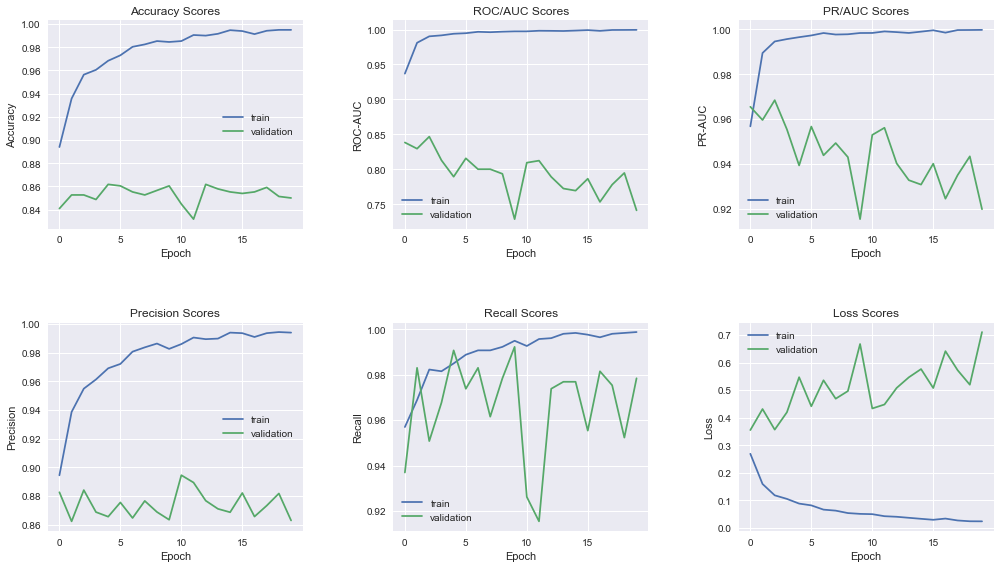

In [16]:
plt.style.use('seaborn-notebook')
sixplot(history3, 'auc_2', 'val_auc_2', 'auc_3', 'val_auc_3', 'precision_1', 'val_precision_1', 'recall_1', 'val_recall_1')

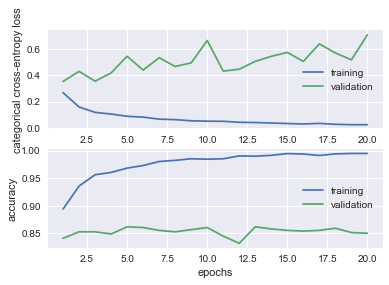

In [23]:
train_val_metrics(20, history3)

In [57]:
hist_df_3 = pd.DataFrame(history3.history)
hist_df_3

,loss,accuracy,auc_6,auc_7,precision_3,recall_3,val_loss,val_accuracy,val_auc_6,val_auc_7,val_precision_3,val_recall_3
0,5.959352,0.744909,0.758642,0.826092,0.810069,0.815982,12.293129,0.951327,0.527995,0.960942,0.959762,0.990769
1,0.610057,0.819582,0.845289,0.887599,0.835203,0.915098,0.224131,0.958702,0.711566,0.980095,0.958702,1.000000
2,0.451655,0.829504,0.879377,0.923176,0.841865,0.922397,0.316067,0.868732,0.631978,0.975656,0.959083,0.901538
3,0.416313,0.856136,0.920728,0.954409,0.859495,0.942374,0.165416,0.957227,0.818736,0.990093,0.958641,0.998462
4,0.328959,0.861097,0.927976,0.957397,0.872348,0.932002,0.277417,0.895280,0.785549,0.988379,0.969206,0.920000
5,0.287642,0.871279,0.935500,0.962636,0.884475,0.932386,0.222067,0.912979,0.751758,0.985440,0.959565,0.949231
6,0.280256,0.857963,0.934572,0.965333,0.874500,0.923550,0.195969,0.939528,0.830494,0.991259,0.959276,0.978462
7,0.392078,0.869452,0.929319,0.960551,0.885589,0.927776,0.431595,0.871681,0.666017,0.964980,0.966833,0.896923


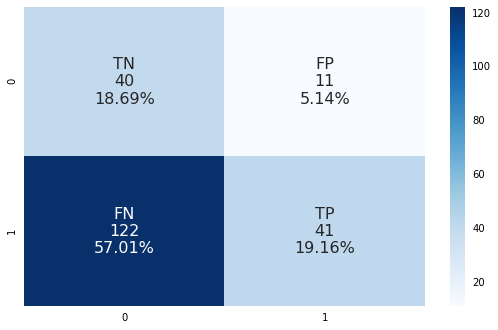

In [58]:
prob = model3.predict_generator(test_generator)
y_true = test_generator.classes
y_pred3 = prob > 0.5
make_confusion_matrix(y_true, y_pred3)

# CNN Model

In [13]:
model5 = cnn((256, 256, 3))
model5.compile(optimizer = Adam(lr=0.001), 
               loss = 'binary_crossentropy',
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [14]:
filepath = '../models/CNN_v2.h5'
# earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')
history5 = model5.fit(train_generator,
                     epochs = 20,
                     callbacks = [earlyStopping, mcp_save],
                     validation_data = val_generator,
                     batch_size=16)

Epoch 1/20
240/240 [==============================] - 708s 3s/step - loss: 0.5421 - accuracy: 0.8008 - auc_6: 0.7680 - auc_7: 0.8279 - precision_3: 0.7972 - recall_3: 0.9476 - val_loss: 0.5568 - val_accuracy: 0.8475 - val_auc_6: 0.7755 - val_auc_7: 0.9491 - val_precision_3: 0.8502 - val_recall_3: 0.9954
Epoch 2/20
240/240 [==============================] - 752s 3s/step - loss: 0.3344 - accuracy: 0.8551 - auc_6: 0.8991 - auc_7: 0.9364 - precision_3: 0.8316 - recall_3: 0.9850 - val_loss: 0.4312 - val_accuracy: 0.8514 - val_auc_6: 0.8261 - val_auc_7: 0.9602 - val_precision_3: 0.8545 - val_recall_3: 0.9938
Epoch 3/20
240/240 [==============================] - 644s 3s/step - loss: 0.2663 - accuracy: 0.8845 - auc_6: 0.9420 - auc_7: 0.9672 - precision_3: 0.8763 - recall_3: 0.9674 - val_loss: 0.5075 - val_accuracy: 0.8044 - val_auc_6: 0.8006 - val_auc_7: 0.9494 - val_precision_3: 0.9153 - val_recall_3: 0.8477
Epoch 4/20
240/240 [==============================] - 660s 3s/step - loss: 0.2320 - a

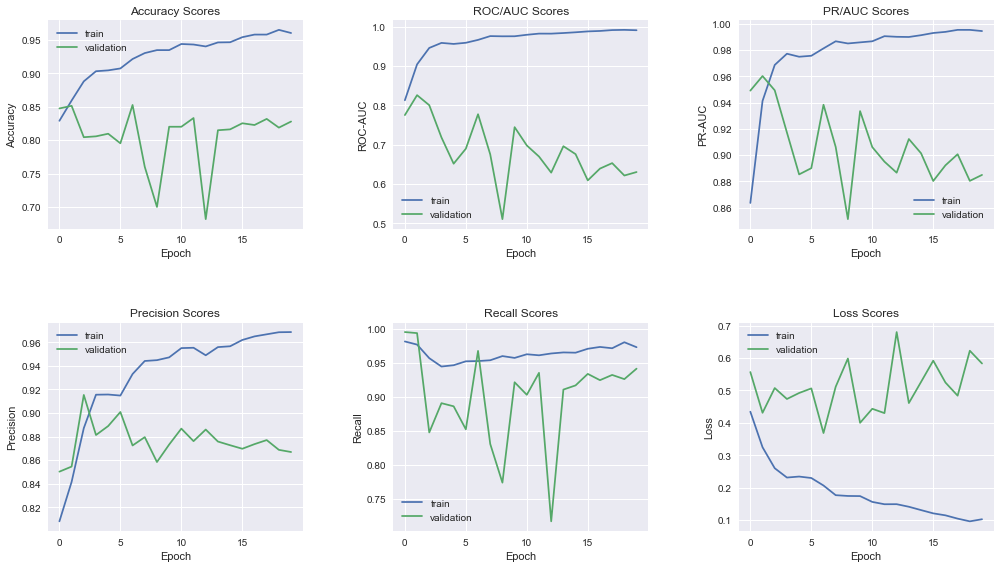

In [24]:
plt.style.use('seaborn')
sixplot(history5, 'auc_6', 'val_auc_6', 'auc_7', 'val_auc_7', 'precision_3', 'val_precision_3', 'recall_3', 'val_recall_3')

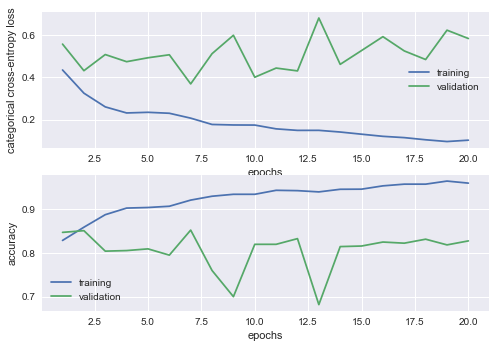

In [23]:
plt.style.use('seaborn')
train_val_metrics(20, history5)

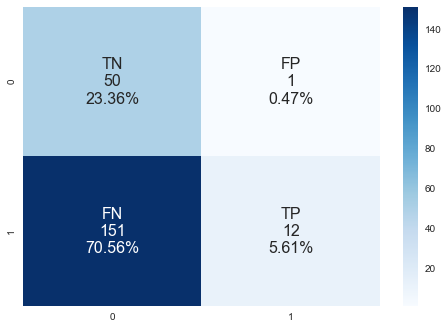

In [31]:
prob5 = model5.predict_generator(test_generator)
y_true = test_generator.classes
y_pred5 = prob5 > 0.5
make_confusion_matrix(y_true, y_pred5)

In [6]:
score = model5.evaluate(X_tt, y_tt, verbose = 1)
labels = model5.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

NameError: name 'model5' is not defined

In [28]:
model6 = cnn((256, 256, 3))
model6.compile(optimizer = Adam(lr=0.001), 
               loss = 'binary_crossentropy',
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

filepath = '../models/CNN_v2.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')
history6 = model5.fit(train_generator,
                     epochs = 20,
                     callbacks = [earlyStopping, mcp_save],
                     validation_data = val_generator,
                     batch_size=16)

Epoch 1/20
240/240 [==============================] - 683s 3s/step - loss: 0.0786 - accuracy: 0.9710 - auc_6: 0.9953 - auc_7: 0.9975 - precision_3: 0.9781 - recall_3: 0.9793 - val_loss: 0.6581 - val_accuracy: 0.7888 - val_auc_6: 0.6544 - val_auc_7: 0.8900 - val_precision_3: 0.8836 - val_recall_3: 0.8646
Epoch 2/20
240/240 [==============================] - 643s 3s/step - loss: 0.0850 - accuracy: 0.9668 - auc_6: 0.9935 - auc_7: 0.9961 - precision_3: 0.9718 - recall_3: 0.9796 - val_loss: 0.6094 - val_accuracy: 0.8357 - val_auc_6: 0.6424 - val_auc_7: 0.8920 - val_precision_3: 0.8732 - val_recall_3: 0.9431
Epoch 3/20
240/240 [==============================] - 653s 3s/step - loss: 0.0690 - accuracy: 0.9723 - auc_6: 0.9956 - auc_7: 0.9971 - precision_3: 0.9771 - recall_3: 0.9823 - val_loss: 0.6178 - val_accuracy: 0.8266 - val_auc_6: 0.6525 - val_auc_7: 0.8860 - val_precision_3: 0.8677 - val_recall_3: 0.9385
Epoch 4/20
240/240 [==============================] - 645s 3s/step - loss: 0.0738 - a

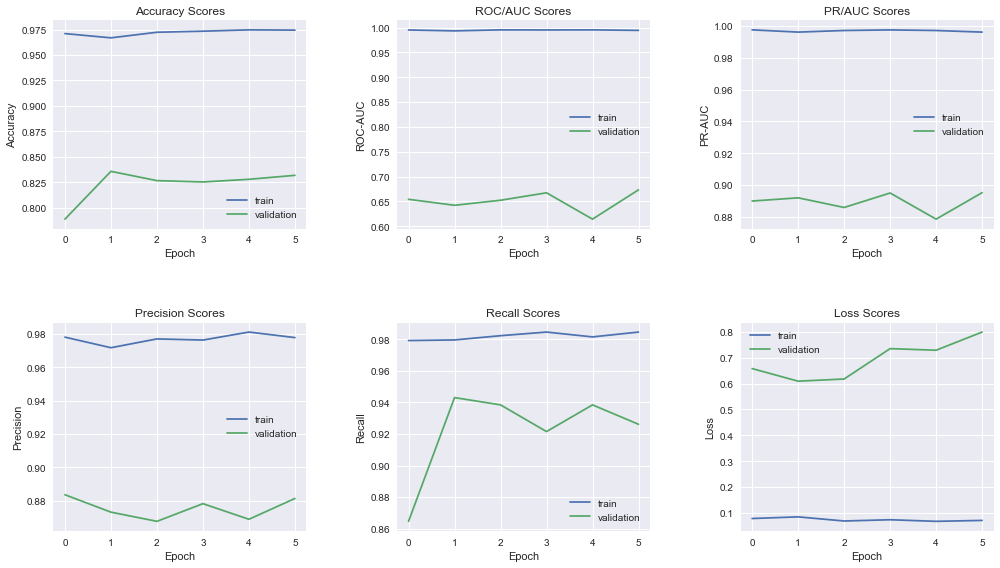

In [30]:
plt.style.use('seaborn')
sixplot(history6, 'auc_6', 'val_auc_6', 'auc_7', 'val_auc_7', 'precision_3', 'val_precision_3', 'recall_3', 'val_recall_3')